## Data Analysis

In [1]:
import matplotlib.pyplot as plt

def char_plot(set, sizes, labels):
    colors = ['yellowgreen', 'gold', 'lightskyblue']

    plt.figure(figsize=(5, 4))
    plt.pie(sizes, labels=labels, colors=colors, startangle=90, autopct='%1.1f%%')

    # Add circle at center to create the effect of a cheese graph
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.title(set.capitalize() + ' Set Class Division')
    plt.axis('equal')  # Ensure circular pie
    plt.tight_layout()  # Avoid overlapping labels
    plt.show()

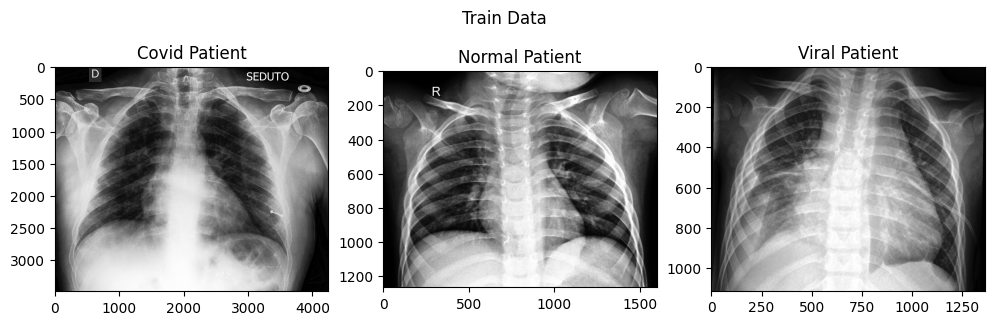

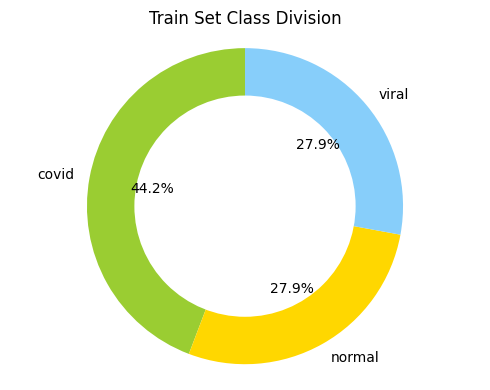

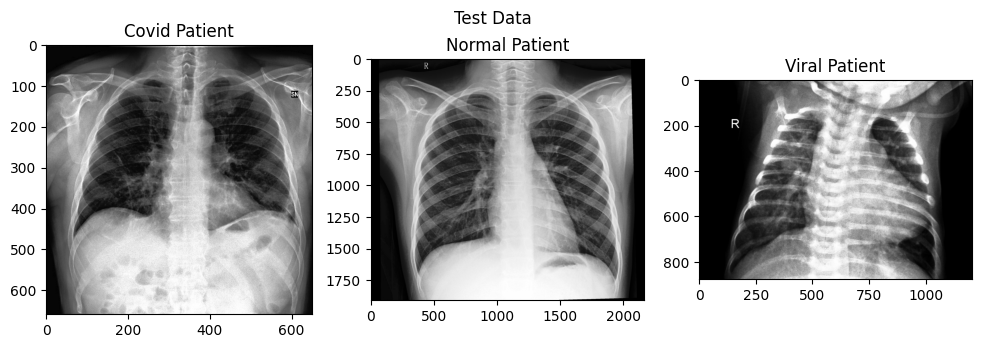

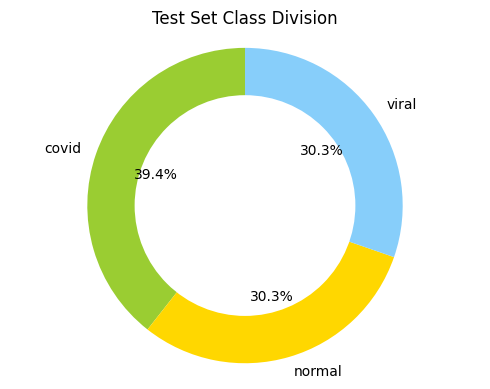

In [2]:
import os
import numpy as np
import matplotlib.image as mpimg

data_path = "./data"
set_path = ["train", "test"]
labels = ['covid', 'normal', 'viral']
sizes = np.zeros(3, dtype=np.int32)

for set in set_path:
    fig = plt.figure(figsize=(12, 3.5))
    fig.suptitle(set.capitalize() + " Data")
    
    for ix, l in enumerate(labels):
        directory_path = data_path + "/" + set + "/" + l
        sizes[ix] = len(os.listdir(directory_path))
        plt.subplot(1, 3, ix + 1)
        plt.imshow(mpimg.imread(directory_path + '/' + str(ix + 1) + ".jpeg"))
        plt.title(l.capitalize() + " Patient")
    plt.show() 

    char_plot(set, sizes, labels)

## Data Augmentation

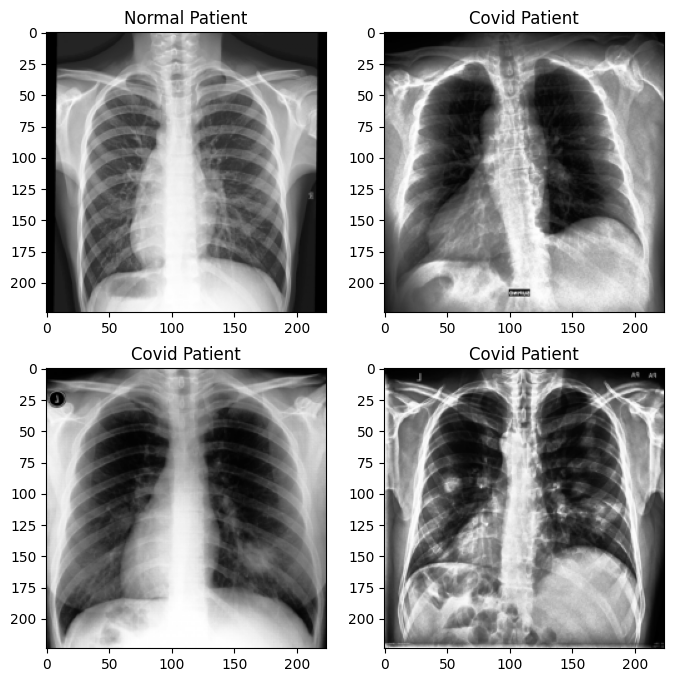

In [45]:
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

augmentation_transform = transforms.Compose([
    transforms.RandomEqualize(1.0),  # Histogram equalization (./docs/papers/article-3.pdf)
    transforms.RandomHorizontalFlip(1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

BATCH_SIZE = 2
augmentation_dataset = datasets.ImageFolder('./data/train/', transform=augmentation_transform)
augmentation_dataloader = DataLoader(augmentation_dataset, batch_size=BATCH_SIZE, shuffle=True)

iterable = iter(augmentation_dataloader)
fig = plt.figure(figsize=(BATCH_SIZE * 4, BATCH_SIZE * 4))

for bix in range(0, BATCH_SIZE):
    image_list, label_list = next(iterable)
    
    for ix, (image, label) in enumerate(zip(image_list, label_list), 1):
        plt.subplot(BATCH_SIZE, BATCH_SIZE, bix * BATCH_SIZE + ix)  # [n_rows, n_cols, index]
        plt.imshow(image.numpy().transpose((1, 2, 0)))  # (C, H, W) -> (H, W, C)
        plt.title(augmentation_dataset.classes[label].capitalize() + " Patient")

plt.show()

## Network Architecture Design

In [4]:
import torch
import torch.nn as nn
import torchvision

# ./docs/papers/article-2.pdf
# Multiclass Classification for Detection of COVID-19 Infection in Chest X-Rays Using CNN
class TabukNet(nn.Module):  # TODO own object to each conv layer
    def __init__(self):
        super().__init__()

        # Check stride and padding
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(in_features=7 * 7 * 64, out_features=3)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x: torch.tensor):
        x = self.maxpool(self.conv1(x))
        x = self.maxpool(self.conv2(x))
        x = self.maxpool(self.conv3(x))
        x = self.maxpool(self.conv4(x))
        x = self.maxpool(self.conv5(x))
        x = self.conv6(x)   
        x = self.fc(x.view(len(x), -1))  # Batched view
        return self.softmax(x)


# ./docs/papers/article-3.pdf
# A Deep Transfer Learning Approach to Diagnose Covid-19 using X-ray Images
class ChittagongNet(nn.Module):
    def __init__(self, mode):
        super().__init__()

        # Very Deep Convolutional Networks for Large-Scale Image Recognition
        # https://arxiv.org/abs/1409.1556
        if mode == "vgg16":
            self.trained_net = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)

        elif mode == "vgg19":
            self.trained_net = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.DEFAULT)

        # MobileNetV2: Inverted Residuals and Linear Bottlenecks
        # https://arxiv.org/abs/1801.04381
        elif mode == "mobile_net":
            self.trained_net = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.DEFAULT)
    
        for param in self.trained_net.parameters():
            param.requires_grad = False

        # Replace fully connected layers
        classifier = self.trained_net.classifier
        n_inputs = classifier[1].in_features if isinstance(classifier[0], nn.Dropout) else classifier[0].in_features
            
        self.trained_net.classifier = nn.Sequential(
            # Dense(1024, activation='relu')
            nn.Linear(in_features=n_inputs, out_features=1024),
            nn.ReLU(),
            # Dense(1024, activation='relu')
            nn.Linear(in_features=1024, out_features=1024),
            nn.ReLU(),
            # nn.Dropout(p=0.2),
            # Dense(512, activation='relu')
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            # nn.Dropout(p=0.2),
            # Dense(3, activation='softmax')
            nn.Linear(in_features=512, out_features=3),
            nn.Softmax(dim=1)
        )

        for param in self.trained_net.classifier.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.trained_net(x)

## Network Training and Evaluation

### Hyperparameters

In [66]:
import torch

# Define execution device (CPU or GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_RELATIVE_PATH = "./models/"

EPOCHS = 40
BATCH_SIZE = 64
LEARNING_RATE = 0.001

### Dataset Creation

In [6]:
from torch.utils.data import random_split
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader, ConcatDataset

transform = transforms.Compose([
    transforms.RandomEqualize(1.0),  # Histogram equalization (./docs/papers/article-3.pdf)
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_val_dataset = ConcatDataset([datasets.ImageFolder('./data/train/', transform=transform), augmentation_dataset])
test_dataset = datasets.ImageFolder('./data/test/', transform=transform)

train_size, val_size = 0.8, 0.2
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Train and Test Functions

In [7]:
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score

fscore = MulticlassF1Score(num_classes=3, average='macro')
accuracy = MulticlassAccuracy(num_classes=3, average='macro')

def test(network: nn.Module, dataloader, criterion):
    network.eval()
    
    test_loss = 0
    test_fscore = 0
    test_accuracy = 0

    num_batches = 0

    with torch.no_grad():
        for images, labels in dataloader:  # [BATCH_SIZE, CHANNELS, HEIGHT, WIDTH]

            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            predicted = network(images)
            
            test_loss += criterion(predicted, labels)
            test_fscore += fscore(predicted, labels)
            test_accuracy += accuracy(predicted, labels)

            num_batches += 1

        return test_loss / num_batches, test_fscore / num_batches, test_accuracy / num_batches

In [8]:
import math
import torch.nn as nn
from torch.utils.tensorboard.writer import SummaryWriter

def train_validate(network: nn.Module, epochs, train_loader, val_loader, criterion, optimizer):
    writer = SummaryWriter("./logs")
    best_fscore, best_network = -math.inf, None

    for epoch in range(epochs):
        network.train()
        
        train_loss = 0
        train_fscore = 0
        train_accuracy = 0

        num_batches = 0

        for images, labels in train_loader:  # [BATCH_SIZE, CHANNELS, HEIGHT, WIDTH]

            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            predicted = network(images)
            
            loss = criterion(predicted, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_fscore += fscore(predicted, labels)
            train_accuracy += accuracy(predicted, labels)

            num_batches += 1

        train_loss /= num_batches
        train_fscore /= num_batches
        train_accuracy /= num_batches

        val_loss, val_fscore, val_accuracy = test(network, val_loader, criterion)
        if(val_fscore > best_fscore):
            best_fscore = val_fscore
            best_network = network.state_dict()

        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("Loss/val", val_loss, epoch)
        
        writer.add_scalar("Fscore/train", train_fscore, epoch)
        writer.add_scalar("Fscore/val", val_fscore, epoch)

        writer.add_scalar("Accuracy/train", train_accuracy, epoch)
        writer.add_scalar("Accuracy/val", val_accuracy, epoch)

        print(f'[{int((epoch + 1.0) / epochs * 100)}%] train loss: {train_loss:.3f}, val loss: {val_loss:.3f}, train fscore: {train_fscore:.3f}, val fscore: {val_fscore:.3f}')

    writer.flush()
    writer.close()
    
    return best_network

In [9]:
import os
import torch
from torch.optim import Adam
from torchsummary import summary
from torch.nn import CrossEntropyLoss

def load_prepare_network(network, path):
    criterion = CrossEntropyLoss()
    model_path = MODEL_RELATIVE_PATH + path
    
    if not os.path.isfile(model_path):
        os.makedirs(os.path.dirname(model_path), exist_ok=True)

        optimizer = Adam(params=network.parameters(), lr=LEARNING_RATE)

        state_dict = train_validate(network, EPOCHS, train_loader, val_loader, criterion, optimizer)  # TODO Cross validation (sklearn)
        torch.save(state_dict, model_path)
    else:
        network.load_state_dict(torch.load(model_path))
        summary(model=network, input_size=(3, 224, 224))

    test_loss, test_fscore, test_accuracy = test(network, test_loader, criterion)
    print(f'test loss: {test_loss:.3f}, test fscore: {test_fscore:.3f}, test accuracy: {test_accuracy:.3f}')

    return network

### TabukNet - Multiclass Classification for Detection of COVID-19 Infection in Chest X-Rays Using CNN

In [19]:
network = load_prepare_network(TabukNet().to(DEVICE), 'tabuk.pth')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 32, 56, 56]          18,464
         MaxPool2d-6           [-1, 32, 28, 28]               0
            Conv2d-7           [-1, 64, 28, 28]          18,496
         MaxPool2d-8           [-1, 64, 14, 14]               0
            Conv2d-9           [-1, 32, 14, 14]          18,464
        MaxPool2d-10             [-1, 32, 7, 7]               0
           Conv2d-11             [-1, 64, 7, 7]          18,496
           Linear-12                    [-1, 3]           9,411
          Softmax-13                    [-1, 3]               0
Total params: 102,723
Trainable params:

### ChittagongNet - A Deep Transfer Learning Approach to Diagnose Covid-19 using X-ray Images

In [11]:
for mode in ['vgg16', 'vgg19', 'mobile_net']:
    network = load_prepare_network(ChittagongNet(mode).to(DEVICE), 'chittagong_' + mode + '.pth')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## Results

### Activation Maps on First Convolutional Layer

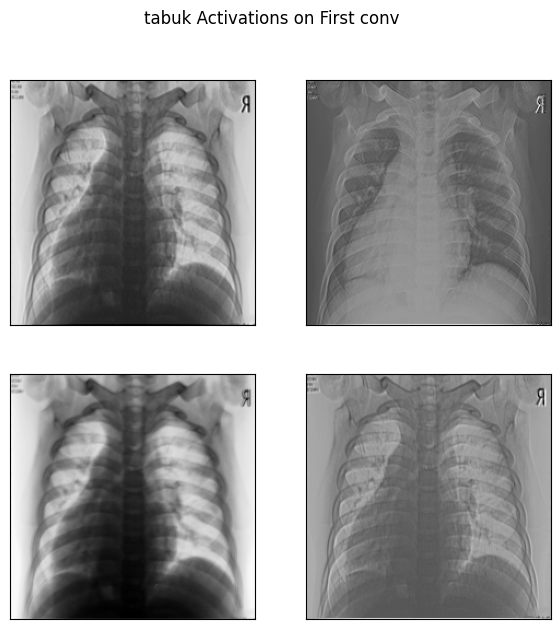

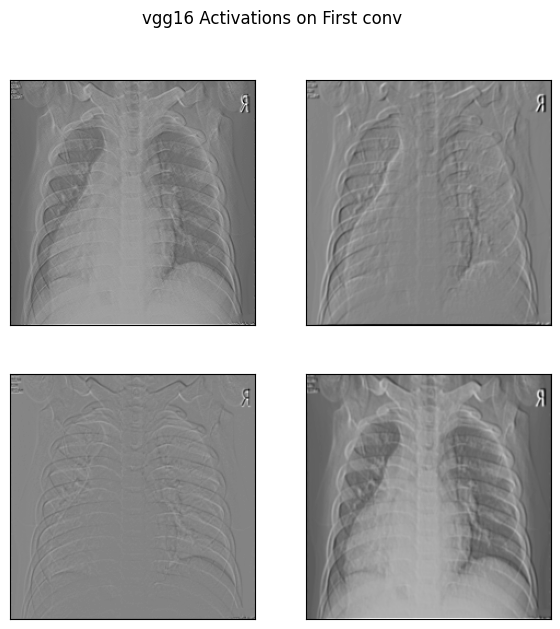

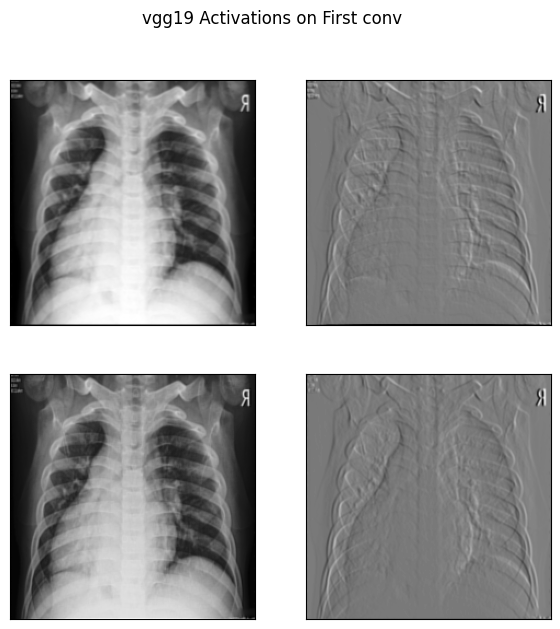

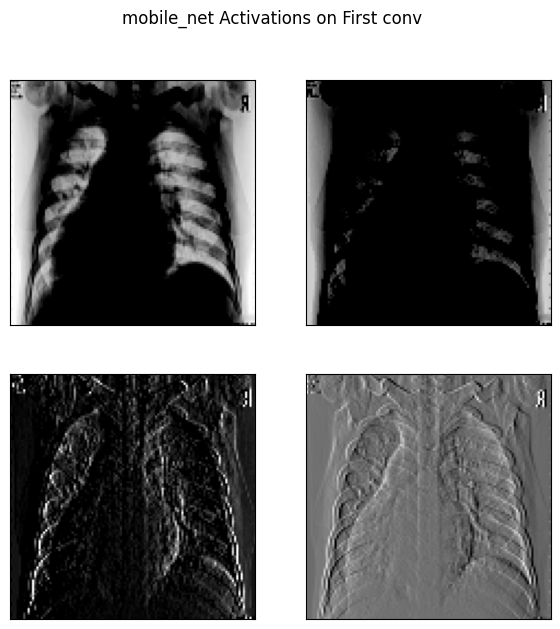

In [31]:
image = next(iter(train_loader))[0][0]

for mode in ['tabuk', 'vgg16', 'vgg19', 'mobile_net']:
    with torch.no_grad():
        if mode == 'tabuk':
            image = image.unsqueeze(0)

        if mode == 'tabuk':
            network = TabukNet()
            network.load_state_dict(torch.load(MODEL_RELATIVE_PATH + mode + '.pth'))

            feature_maps = network.conv1(image)
        else:
            network = ChittagongNet(mode)
            network.load_state_dict(torch.load(MODEL_RELATIVE_PATH + 'chittagong_' + mode + '.pth'))
            
            feature_maps = network.trained_net.features[0](image)

        feature_maps = feature_maps.squeeze(0)

        fig = plt.figure(figsize=(7, 7))
        fig.suptitle(mode + ' Activations on First conv')

        position = 1
        for i in range(4):
            ax = plt.subplot(2, 2, position)
            ax.set_xticks([])
            ax.set_yticks([])

            feature = feature_maps[i].cpu().numpy()
            plt.imshow(feature, cmap='gray')
            position += 1
        
        plt.show()

### GradCam Visualization of Gradients

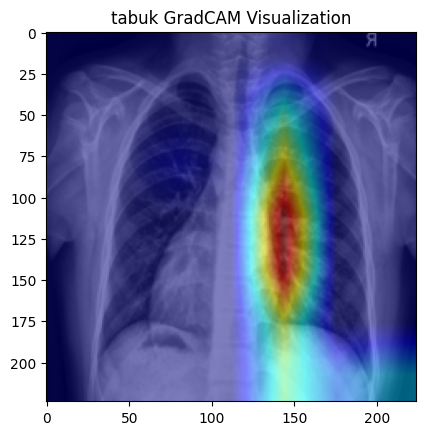

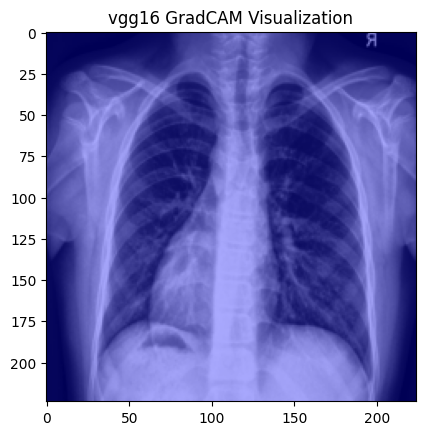

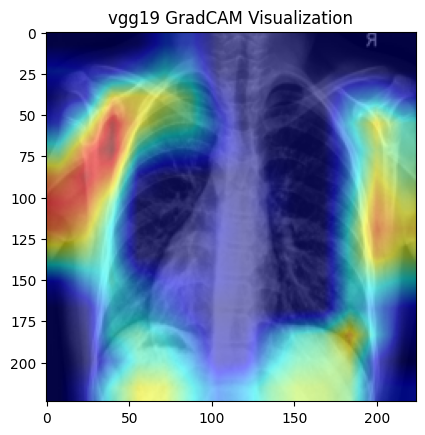

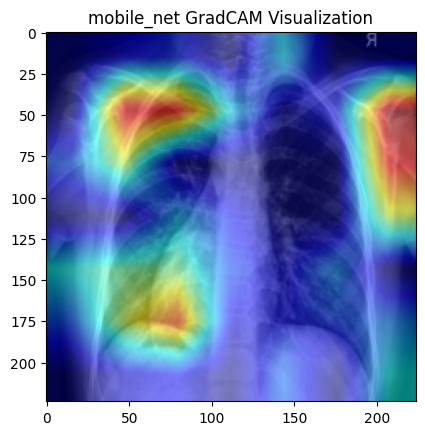

In [137]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

batch_tensor = next(iter(train_loader))[0]

for mode in ['tabuk', 'vgg16', 'vgg19', 'mobile_net']:
    if mode == 'tabuk':
        network = TabukNet()
        network.load_state_dict(torch.load(MODEL_RELATIVE_PATH + mode + '.pth'))

        target_layers = [network.conv6]

    else:
        network = ChittagongNet(mode)
        network.load_state_dict(torch.load(MODEL_RELATIVE_PATH + 'chittagong_' + mode + '.pth'))
        network = network.trained_net

        target_layers = [network.features[-3]]

        for param in network.parameters():
            param.requires_grad = True

    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=network, target_layers=target_layers, use_cuda=0)
    
    grayscale_cam = cam(input_tensor=batch_tensor[0].unsqueeze(0), targets=None)
    grayscale_cam = grayscale_cam[0, :]

    visualizations= show_cam_on_image(batch_tensor[0].numpy().transpose(1, 2, 0), grayscale_cam, use_rgb=True)
    plt.imshow(visualizations)
    plt.title(mode + ' GradCAM Visualization')
    plt.show()


### t-SNE Visualization of CNN High Dimensional Features

In [14]:
from sklearn.manifold import TSNE

def visualize_tsne(features, labels, net_name):
        tsne_transformed = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(features)
        
        fig, ax = plt.subplots()
        scatter = ax.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=labels)
        
        fig.colorbar(scatter)

        plt.xlabel('t-SNE dimension 1')
        plt.ylabel('t-SNE dimension 2')
        plt.title(net_name + ' t-SNE plot')

        plt.show()

(64, 3136)


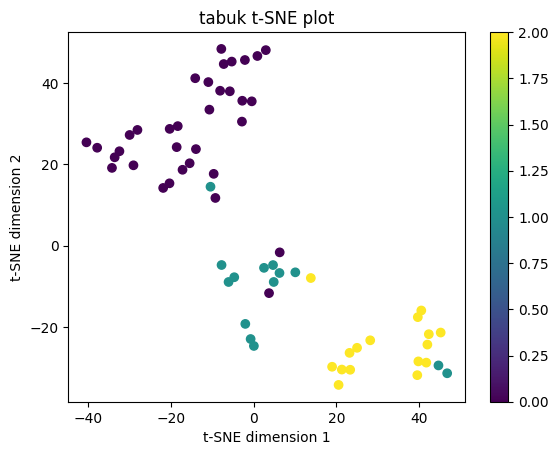

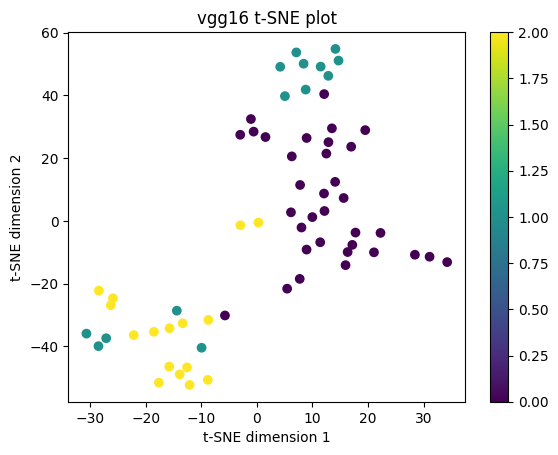

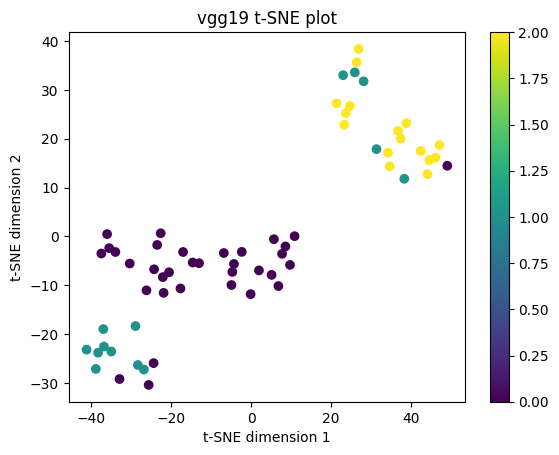

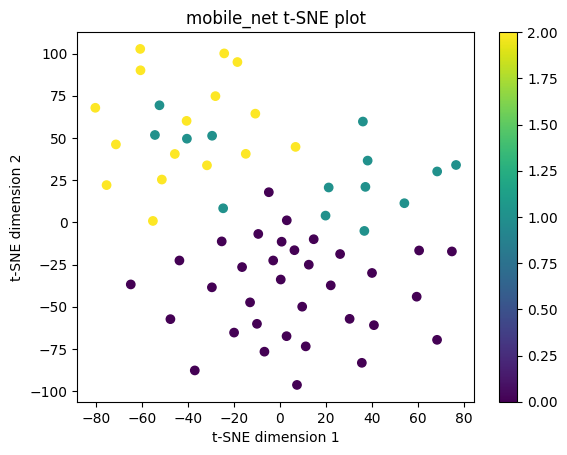

In [67]:
batch = next(iter(train_loader))
images, labels = batch[0], batch[1]

for mode in ['tabuk', 'vgg16', 'vgg19', 'mobile_net']:
    with torch.no_grad():
        if mode == 'tabuk':
            network = TabukNet()
            network.load_state_dict(torch.load(MODEL_RELATIVE_PATH + mode + '.pth'))

            x = network.maxpool(network.conv1(images))
            x = network.maxpool(network.conv2(x))
            x = network.maxpool(network.conv3(x))
            x = network.maxpool(network.conv4(x))
            x = network.maxpool(network.conv5(x))
            features = network.conv6(x).view(BATCH_SIZE, -1).cpu().numpy() 
            print(features.shape)

        else:
            network = ChittagongNet(mode)
            network.load_state_dict(torch.load(MODEL_RELATIVE_PATH + 'chittagong_' + mode + '.pth'))
            network = network.trained_net.features

            features = network(images).view(BATCH_SIZE, -1).cpu().numpy() 

        visualize_tsne(features, labels, mode)